In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\osaz001\Master-thesis\Files\func.py:21: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 50

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models

"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5621 - loss: 0.2419 - val_accuracy: 0.5700 - val_loss: 0.2399
Epoch 2/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5802 - loss: 0.2380 - val_accuracy: 0.5847 - val_loss: 0.2373
Epoch 3/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5929 - loss: 0.2350 - val_accuracy: 0.5860 - val_loss: 0.2352
Epoch 4/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6063 - loss: 0.2308 - val_accuracy: 0.6000 - val_loss: 0.2314
Epoch 5/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6140 - loss: 0.2279 - val_accuracy: 0.6184 - val_loss: 0.2268
Epoch 6/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6240 - loss: 0.2246 - val_accuracy: 0.6256 - val_loss: 0.2229
Epoch 7/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6333 - loss: 0.2217 - val_accuracy: 0.6279 - val_loss: 0.2219
Epoch 8/50
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6367 - loss: 0

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Ridge Classifier:
Accuracy: 0.5311952843800223
Confusion Matrix:
[[54680 43399]
 [47904 48774]]
Precision: 52.91571284432535
Recall: 50.449947247564076
F1 Score: 51.65341989187242
MSE: 46.88047156199777
RMSE: 68.46931543545458


XGBoost Classifier:
Accuracy: 0.5282839641193898
Confusion Matrix:
[[54641 43438]
 [48432 48246]]
Precision: 52.62204964879368
Recall: 49.90380438155527
F1 Score: 51.226892897718216
MSE: 47.17160358806102
RMSE: 68.68158675224461


LightGBM Classifier:
Accuracy: 0.525593431815031
Confusion Matrix:
[[53843 44236]
 [48158 48520]]
Precision: 52.30928457458278
Recall: 50.18721942944621
F1 Score: 51.22628461627797
MSE: 47.4406568184969
RMSE: 68.87717823669674


Neural Network:
Accuracy: 0.5052552668196778
Confusion Matrix:
[[50618 47461]
 [48894 47784]]
Precision: 50.169562706703765
Recall: 49.425

In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [9]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [10]:
"""def update_df_with_asset_performance(df, portfolios, value, hold_days):
     #Update df by marking assets in portfolios with a specified value starting two days after for a duration. 
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value


# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 1, target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], -1, target_days)"""




"def update_df_with_asset_performance(df, portfolios, value, hold_days):\n     #Update df by marking assets in portfolios with a specified value starting two days after for a duration. \n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) \n\n    # Accumulate best and worst assets for each date\n    for date in best_assets['todate'].unique():\n        po

In [11]:
import pandas as pd

def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):
    """ Update df by marking assets in portfolios with normalized values 
    starting two days after for a duration, such that the absolute sum of values is 1."""
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 5s 889us/step


In [12]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [13]:
%reload_ext autoreload
%autoreload 2


In [14]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [15]:
xgb_trade_volume.sum()

4178

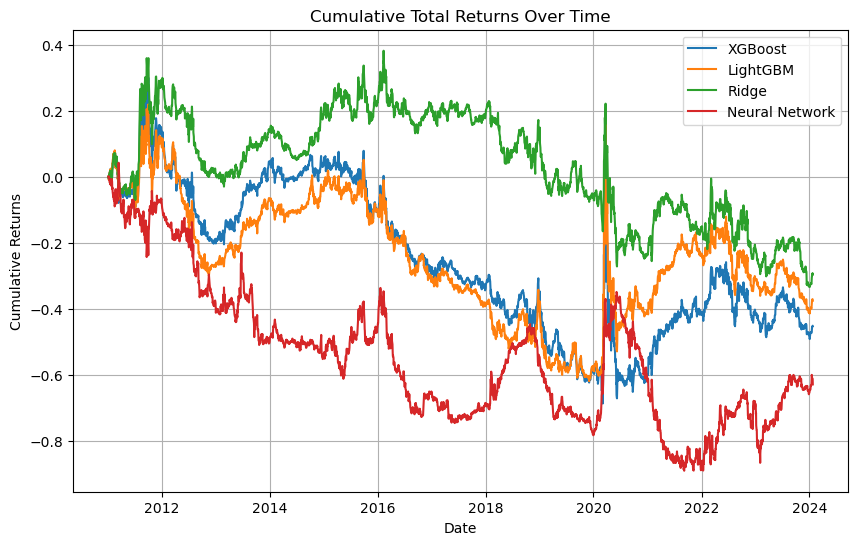

In [16]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = xgb_total_returns.cumsum()
lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [17]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
4178


LightGBM trade volume:
3070


Ridge trade volume:
2726


Neural Network trade volume:
3094




In [18]:
# alla olika ratios föpr olika portföljer som sharpe osv
# fixa NN
xgb_targets = add_target(xgb_returns, [target_days])
lgb_targets = add_target(lgb_returns, [target_days])
ridge_targets = add_target(ridge_returns, [target_days])
NN_targets = add_target(NN_returns, [target_days])

In [19]:
xgb_transformed = transform_and_pivot_df(xgb_targets, date_col)
lgb_transformed = transform_and_pivot_df(lgb_targets, date_col)
ridge_transformed = transform_and_pivot_df(ridge_targets, date_col)
NN_transformed = transform_and_pivot_df(NN_targets, date_col)


In [20]:
xgb_transformed.head(25)

,todate,asset,avgreturn_50,sharpe_ratio,volatility_50
0,2011-02-08,EQS_0,0.000151,0.177500,0.000853
1,2011-02-08,EQS_1,0.000000,NaN,0.000000
2,2011-02-08,EQS_10,-0.000037,-0.054832,0.000672
3,2011-02-08,EQS_2,0.000128,0.141252,0.000904
4,2011-02-08,EQS_3,0.000214,0.363539,0.000588
5,2011-02-08,EQS_4,0.000299,0.389975,0.000768
6,2011-02-08,EQS_5,-0.000055,-0.278739,0.000196
7,2011-02-08,EQS_6,-0.000058,-0.140596,0.000414
8,2011-02-08,EQS_7,0.000168,0.253781,0.000662
9,2011-02-08,EQS_8,0.000102,0.144411,0.000710


In [1]:
# average return and volatility and sharpe per model

ridge_cumulative_total_returns.mean()*252

NameError: name 'ridge_cumulative_total_returns' is not defined